In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

from util_train import *
from utils import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [39]:
reference_date = pd.to_datetime("2023-01-01")

In [2]:
train_df = pd.read_csv("./data/train_data_after_EDA.csv", index_col="Claim Identifier")

In [12]:
numerical_features = [
    "Age at Injury",
    #"IME-4 Count",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    #"Accident Days",
    #"Assembly Days",
    #"Age"
    "Days Past Accident",
    "Assembly Years past Accident"
]

categorical_features = [
    'Carrier Name',
     'Carrier Type',
     'County of Injury',
     'District Name',
     'Gender',
     'Medical Fee Region',
     "Zip Code"]

binary_features = ['Alternative Dispute Resolution',
     'Attorney/Representative',
     'COVID-19 Indicator',
     'First Hearing Date Occurred',
     'C-2 Date Occurred',
     'C-3 Date Occurred']


In [13]:
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
print("-------")
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Birth Year
Claim Injury Type


In [15]:
train_df = train_df.drop(["Accident Date", "Birth Year"],axis=1)

In [16]:
X = train_df.drop(["Claim Injury Type"], axis = 1)
y = train_df["Claim Injury Type"]

In [17]:
X_train_90, X_test, y_train_90, y_test = train_test_split(X,y, test_size = 0.1, random_state = 69, stratify = y, shuffle = True)

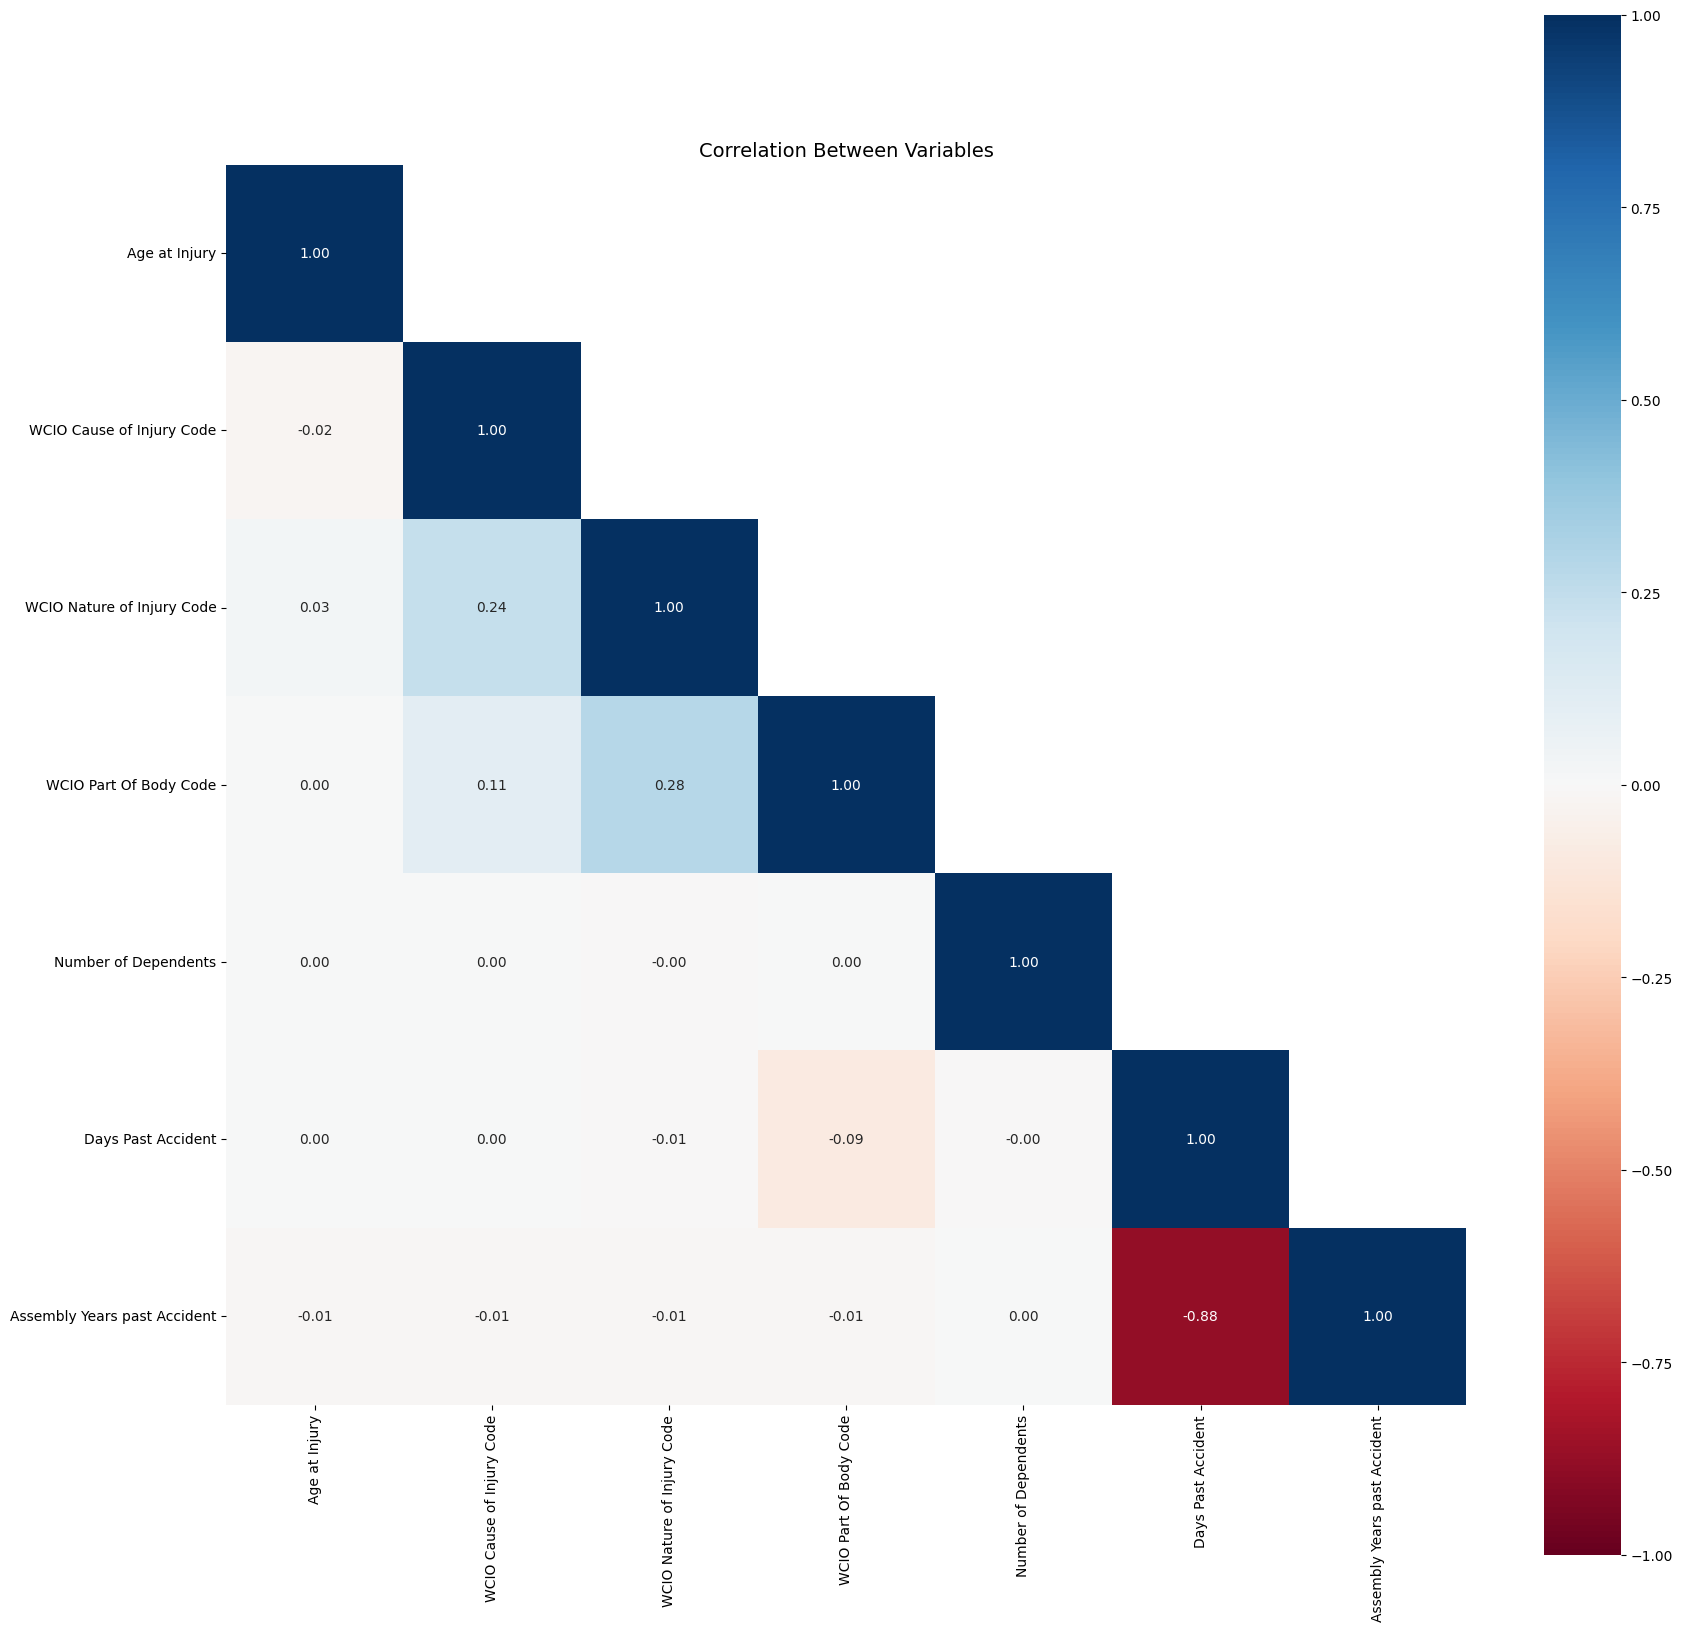

In [18]:
# initial correlation matrix with the respective values
corr_matrix = X_train_90[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

In [19]:
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

In [20]:
feature_to_scale = numerical_features+categorical_features
mm = MinMaxScaler()
X_train_temp[feature_to_scale] = mm.fit_transform(X_train_temp[feature_to_scale])
X_val_temp[feature_to_scale] = mm.transform(X_val_temp[feature_to_scale])

In [21]:
RFE_LR_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = LogisticRegression(class_weight='balanced'))

In [22]:
RFE_DT_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced'))

In [23]:
RFE_LR_best

['Age at Injury',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Days Past Accident',
 'Assembly Years past Accident']

In [24]:
RFE_DT_best

['Age at Injury', 'WCIO Nature of Injury Code']

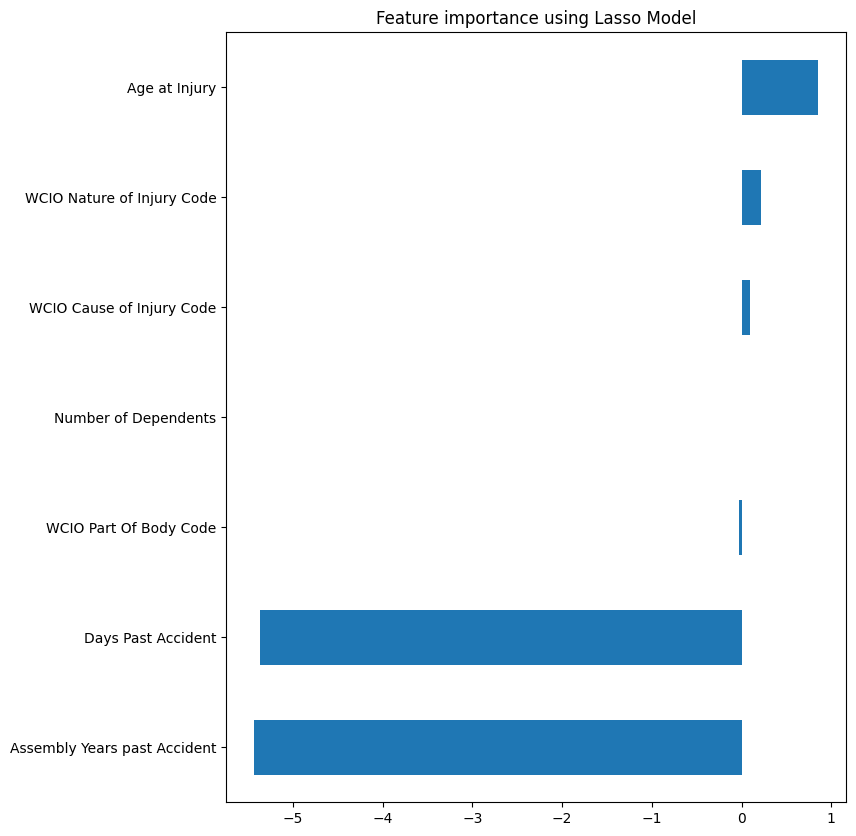

Age at Injury                   0.852574
WCIO Cause of Injury Code       0.095659
WCIO Nature of Injury Code      0.212911
WCIO Part Of Body Code         -0.032484
Number of Dependents            0.001096
Days Past Accident             -5.363486
Assembly Years past Accident   -5.429774
dtype: float64


In [25]:
feature_selection_Lasso(X_train_temp[numerical_features],y_train_temp)

In [26]:
for col in categorical_features+binary_features:
    TestIndependence(X_train_temp[col],y,col,alpha=0.05)

Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
First Hearing Date Occurred is IMPORTANT for Prediction
C-2 Date Occurred is IMPORTANT for Prediction
C-3 Date Occurred is IMPORTANT for Prediction


<hr>

### Numerical Data

| Predictor | Spearman | RFE LR| RFE DT | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | Keep? | Keep | Discard |Keep? | Try with and without |
| IME-4 Count | Keep | Keep | Keep |Keep| Include in the model |
| WCIO Cause of Injury Code | Keep?| Keep | Keep | Discard | Try with and without |
| WCIO Nature of Injury Code | Keep? | Keep | Keep | Discard | Try with and without |
| WCIO Part Of Body Code | Keep | Keep | Keep | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Discard | Discard | Discard |
| Accident Days | Keep |Keep |Keep | Keep? |  Include in the model |
| Assembly Days | Keep |Keep |Discart | Keep? |  Try with and without |
| First Hearing Days | Keep |Keep |Keep | Keep |   Include in the model |
| Age | Keep |Discard |Discard | Keep? |  Discard |
| C-2 Days | Keep |Keep |Keep | Keep |  Include in the model |
| C-3 Days | Keep |Keep |Keep | Keep |  Include in the model |

<hr>


### Categorical Data

| Predictor | Chi-Square |
| --- | --- |
| Carrier Name | Keep |  
| Carrier Type | Keep |
| County of Injury| Keep|
| District Name| Keep|
| Gender | Keep |
| Medical Fee Region | Keep |
| Attorney/Representative | Keep |
| COVID-19 Indicator | Keep |
| First Hearing Date Occurred | Keep |
| C-2 Date Occurred | Keep |
| C-3 Date Occurred| Keep |
| Birth Year Occurred | Keep |
| Age at Injury Occurred | Keep |
| Accident Date Occurred | KEEP |

<hr>

In [17]:
# MAYBE DO KFOLD BEFORE THEM TRAIN MODELS

In [27]:
features_to_drop = ["Number of Dependents","Assembly Years past Accident","WCIO Part Of Body Code"]

In [28]:
X_train_reduced = X_train_90.drop(features_to_drop, axis=1)

In [29]:
features_scale=numerical_features
for feature in features_to_drop:
    features_scale.remove(feature)

In [30]:
# IME-4 remove or change to dummy

In [31]:
n_folds = 5
K_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

models = []
scaler_means = []
scaler_vars = []
   
for train_index, val_index in K_fold.split(X_train_90, y_train_90):
    fold = 1
    X_train, X_val = X_train_90.iloc[train_index], X_train_90.iloc[val_index]
    y_train, y_val = y_train_90.iloc[train_index], y_train_90.iloc[val_index]


    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
        
    scaler = StandardScaler().fit(X_train[features_scale])
    X_train[features_scale]  = scaler.transform(X_train[features_scale])
    X_val[features_scale]  = scaler.transform(X_val[features_scale])  
    
    scaler_means.append(scaler.mean_)
    scaler_vars.append(scaler.var_)

    model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None).fit(X_train, y_train)
    model.fit(X_train, y_train)

    # Model that can find classes with very low data
    
    models.append(model)
    
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    print(f"Fold {fold} validation F1 score: {f1:.4f}")
    fold+=1


Fold 1 validation F1 score: 0.1992
Fold 1 validation F1 score: 0.2294
Fold 1 validation F1 score: 0.2085
Fold 1 validation F1 score: 0.1983
Fold 1 validation F1 score: 0.2089


In [32]:
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [33]:
final_scaler_mean = np.mean(scaler_means, axis=0)
final_scaler_var = np.mean(scaler_vars, axis=0)

final_scaler = StandardScaler()
final_scaler.mean_ = final_scaler_mean
final_scaler.scale_ = np.sqrt(final_scaler_var)

X_test[features_scale] = final_scaler.transform(X_test[features_scale])

pred_test_probs = np.zeros((X_test.shape[0], len(test_encoder.classes_)))  # criar um array para meter as probabilidades

for model in models:
    pred_test_prob = model.predict_proba(X_test) 
    pred_test_probs += pred_test_prob / n_folds 

pred_test = np.argmax(pred_test_probs, axis=1)

In [34]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.18      0.59      0.27      1074
           1       0.77      0.40      0.53     28803
           2       0.14      0.37      0.20      6862
           3       0.60      0.07      0.13     14791
           4       0.40      0.42      0.41      4826
           5       0.04      0.73      0.07       421
           6       0.00      0.30      0.00        10
           7       0.04      0.72      0.07        47

    accuracy                           0.32     56834
   macro avg       0.27      0.45      0.21     56834
weighted avg       0.60      0.32      0.37     56834



In [62]:
# JOIN 2 MODELS

In [ ]:
# TRAIN MODELS

In [ ]:
break

In [93]:
test_df = pd.read_csv("./data/test_data.csv", index_col="Claim Identifier")
submission = pd.read_csv("./data/sample_submission.csv")
test_encoder_dict = {}

In [94]:
features_to_encode_freq = [ 
    "Carrier Name", "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Alternative Dispute Resolution"]

#features_to_encode_ordinal = ["Carrier Type", "Claim Injury Type"]

features_to_metadata = ["Industry Code Description","WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
                        "WCIO Nature of Injury Description", "WCIO Part Of Body Description"
]

features_to_dummy = ["First Hearing Date", "C-2 Date", "C-3 Date"]
features_to_days = ["Assembly Date","First Hearing Date"]

In [95]:
test_df["Days Past Accident"] = (pd.to_datetime(test_df["Accident Date"], errors='coerce') - reference_date).dt.days / 365.25

In [96]:
zip_code_anomalies = test_df[test_df['Zip Code'].notna()  # 'Zip Code' is not missing
        & test_df['Zip Code'].apply(lambda x: not str(x).isnumeric())]  # 'Zip Code' is not numeric

In [97]:
test_df.loc[test_df['Zip Code'].isin(zip_code_anomalies['Zip Code']), 'Zip Code'] = np.nan
test_df["Age at Injury"] = test_df["Age at Injury"].replace(0, np.nan)
test_df["Birth Year"] = test_df["Birth Year"].replace(0, np.nan)
test_df["Gender"] = test_df["Gender"].replace("U","X")

In [98]:
test_df['Accident Date'] = pd.to_datetime(test_df['Accident Date'], errors='coerce')
test_df['Birth Year'] = test_df['Birth Year'].fillna(
    test_df['Accident Date'].dt.year - test_df['Age at Injury']
)

In [99]:
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 0.63% missing values
Age at Injury: 0.84% missing values
Average Weekly Wage: 4.95% missing values
Birth Year: 0.25% missing values
C-2 Date: 2.35% missing values
C-3 Date: 78.04% missing values
First Hearing Date: 88.91% missing values
IME-4 Count: 90.91% missing values
Industry Code: 1.99% missing values
Industry Code Description: 1.99% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 2.67% missing values
WCIO Cause of Injury Description: 2.67% missing values
WCIO Nature of Injury Code: 2.72% missing values
WCIO Nature of Injury Description: 2.72% missing values
WCIO Part Of Body Code: 2.46% missing values
WCIO Part Of Body Description: 2.46% missing values
Zip Code: 5.06% missing values
Days Past Accident: 0.63% missing values


In [100]:
multiencoder(test_df, features_to_encode_freq, "frequency", test_encoder_dict)
multiencoder(test_df, features_to_encode_binary, "binary", test_encoder_dict)
gen_dummy(test_df,features_to_dummy)
date_past_accident(test_df, features_to_days)

In [101]:
#train_df["IME-4 Count"].fillna(0,inplace=True)
test_df["WCIO Cause of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Nature of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Part Of Body Code"].fillna(0,inplace=True)
test_df["Zip Code"].fillna(0,inplace=True)

In [102]:
features_to_drop_test = features_to_metadata + features_to_days + features_to_dummy + ["Average Weekly Wage","Industry Code","OIICS Nature of Injury Description"]

In [103]:
test_df = test_df.drop(features_to_drop_test, axis = 1)

In [104]:
test_df = test_df.drop(["IME-4 Count","Accident Date","Birth Year","FirstHearing Years past Accident"], axis = 1)

In [105]:
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [106]:
test_df.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Days Past Accident,First Hearing Date Occurred,C-2 Date Occurred,C-3 Date Occurred,Assembly Years past Accident
Claim Identifier,,,,,,,,,,,,,,,,,,,,
6165911,19.0,0,0,0.019519,0,0.072293,0,0.484495,0.555043,0.469814,31.0,10.0,54.0,0.004222,1,-0.021903,0,1,0,0.024641
6166141,19.0,0,0,0.018290,0,0.104022,0,0.484495,0.430489,0.469814,75.0,10.0,10.0,0.002544,1,-0.114990,0,1,0,0.117728
6165907,59.0,0,0,0.000369,0,0.045328,0,0.484495,0.430489,0.089385,68.0,49.0,62.0,0.000538,0,-0.016427,0,1,0,0.019165
6166047,55.0,0,0,0.033154,0,0.104022,0,0.484495,0.430489,0.469814,25.0,10.0,53.0,0.001379,6,-0.010951,0,1,0,0.013689
6166102,25.0,0,0,0.007109,0,0.092576,0,0.484495,0.555043,0.469814,79.0,40.0,37.0,0.004849,5,-0.032854,0,1,0,0.035592


In [107]:
final_scaler_mean = np.mean(scaler_means, axis=0)
final_scaler_var = np.mean(scaler_vars, axis=0)

final_scaler = StandardScaler()
final_scaler.mean_ = final_scaler_mean
final_scaler.scale_ = np.sqrt(final_scaler_var)

test_df[features_scale] = final_scaler.transform(test_df[features_scale])

pred_test_probs = np.zeros((test_df.shape[0], len(test_encoder.classes_)))  # criar um array para meter as probabilidades

for model in models:
    pred_test_prob = model.predict_proba(test_df) 
    pred_test_probs += pred_test_prob / n_folds 

pred_test = np.argmax(pred_test_probs, axis=1)

In [108]:
submission["Claim Injury Type"] = pred_test
submission["Claim Injury Type"] =test_encoder.inverse_transform(submission["Claim Injury Type"])

In [109]:
make_csv = False

In [110]:
if make_csv:
    version = version_control("./counter.txt")
    submission.to_csv(f"./submissions/Group45_Version{version:02}.csv", index=False)

In [ ]:
break

In [ ]:
#train_test_split de 10%

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5
K_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

ensemble = []
scaler_means = []
scaler_vars = []
   
for train_index, val_index in K_fold.split(x, y_encoded):
    
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)  
    
    scaler_means.append(scaler.mean_)
    scaler_vars.append(scaler.var_)

    model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None).fit(X_train, y_train)
    model.fit(x_train, y_train)

    # Model that can find classes with very low data
    
    ensemble.append(model)
    
    y_val_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Fold validation accuracy: {accuracy:.4f}")


In [ ]:
# preprocess test data

In [ ]:
final_scaler_mean = np.mean(scaler_means, axis=0)
final_scaler_var = np.mean(scaler_vars, axis=0)

final_scaler = StandardScaler()
final_scaler.mean_ = final_scaler_mean
final_scaler.scale_ = np.sqrt(final_scaler_var)

test_df = final_scaler.transform(test_df)

pred_test_probs = np.zeros((test_df.shape[0], len(label_encoder.classes_)))  # criar um array para meter as probabilidades

for model in ensemble:
    pred_test_prob = model.predict_proba(test_df) 
    pred_test_probs += pred_test_prob / n_folds 

pred_test = np.argmax(pred_test_probs, axis=1)